## 论文复现报告：DEEP LEARNING FOR MONAURAL SPEECH SEPARATION
**论文地址 **：<a href='http://www.smaragd.is/pubs/huang-icassp2014.pdf'>DEEP LEARNING FOR MONAURAL SPEECH SEPARATION</a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa
import librosa.display
import seaborn as sns
import pandas as pd
from pydub import AudioSegment
import warnings
from train_model_tf import *
from context import *
from sphfile import SPHFile
import mir_eval
import os

warnings.filterwarnings('ignore')
%matplotlib inline
%reload_ext autoreload

/home/brightLLer/anaconda3/envs/speech/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1-音频文件预处理
**wjs0**和**TIMIT**两个语音数据集中的音频的文件头都是NIST，这种文件称为SPH文件，它们都不是正确格式的wav文件，因此需要用SPHFile转换为wav文件.

In [2]:
sphfile = SPHFile('./solution/SA1.WAV')
print(sphfile.format)

{'sample_byte_format': '01', 'sample_rate': 16000, 'sample_n_bytes': 2, 'channel_count': 1, 'sample_coding': 'pcm', 'sample_sig_bits': 16}


SPH文件读取后直接调用如下API写入一个wav文件，需要注意的一点是：** TIMIT数据集中，时域信号内每个采样点的采样位数是16位 **

In [3]:
sphfile.write_wav('./solution/SA1_16bits.wav')

'./solution/SA1_16bits.wav'

语音的后续特征处理（如STFT变换）要用到librosa，librosa比较擅长处理32位采样点数(浮点数)的音频，因此librosa在读取音频的时候会重新提高每个采样点的位数，这样的缺点是会多浪费一倍的空间。

In [4]:
y, sr = librosa.load('./solution/SA1_16bits.wav', sr=16000)
print('采样点的数据类型是：{}'.format(y.dtype))
librosa.output.write_wav('./solution/SA1_32bits.wav', y, sr)

采样点的数据类型是：float32


<img src='./solution/16bTo32b.png' />

In [5]:
y_audio = AudioSegment.from_wav('./solution/SA1_32bits.wav')
y_audio

## 2-数据增强算法
尽管TIMIT数据集较大，但每个说话人的语音段仅有10段，如果仅仅用这寥寥数段音频来训练必然要发生过拟合，为了增加训练数据，作者采用的数据增强方案是在时域信号上循环移位，比如假设移动的间隔设置为2，如给出一段信号为`[0.1, 0.2, 0.3, 0.4, 0.5]`，那么一次移位后为`[0.4, 0.5, 0.1, 0.2, 0.3]`，这时候一段语音如果是`I am a student`，那么很有可能在移位后变成了`a student I am`。<br>
具体音频段上，一般移动一次的间隔为0，10k，25k，50k（虽然我设了50，太小了请不要学我）。<br>
关于循环移位算法的更多介绍，请看这里：<a href='https://en.wikipedia.org/wiki/Circular_shift'>Circular shift</a>

In [6]:
signal = np.array([.1, .2, .3, .4, .5], dtype=np.float32)
print("移位之前的信号:")
print(signal)
print("进行一次移位之后的信号（间隔为2）:")
print(shift_one_step(signal, interval=2))

移位之前的信号:
[0.1 0.2 0.3 0.4 0.5]
进行一次移位之后的信号（间隔为2）:
[0.4 0.5 0.1 0.2 0.3]


移动一次显然是不够的，这也是作者认为要循环多次移位，因为这样才产生多个训练样本，至于移动多少次，每次间隔多少个采样点移位，作者并没有明说，我假设的移动次数为，这样一旦信号的长度确定，间隔确定，移动多少次就确定了：
$$
steps = \frac{len(signal)}{interval}
$$

In [7]:
print("原始信号为:\n")
print('origin:', signal)
print("采用间隔1循环移位信号:")
signal_list = circul_shift(signal, verbose=True)
print('一共生成{}个样本\n'.format(len(signal_list)))
print("采用间隔2循环移位信号:")
signal_list = circul_shift(signal, interval=2, verbose=True)
print('一共生成{}个样本'.format(len(signal_list)))

原始信号为:

origin: [0.1 0.2 0.3 0.4 0.5]
采用间隔1循环移位信号:
step 1: [0.5 0.1 0.2 0.3 0.4]
step 2: [0.4 0.5 0.1 0.2 0.3]
step 3: [0.3 0.4 0.5 0.1 0.2]
step 4: [0.2 0.3 0.4 0.5 0.1]
step 5: [0.1 0.2 0.3 0.4 0.5]
一共生成6个样本

采用间隔2循环移位信号:
step 1: [0.4 0.5 0.1 0.2 0.3]
step 2: [0.2 0.3 0.4 0.5 0.1]
一共生成3个样本


## 3-信号的线性混合
<img src='./solution/linear_mixture.png'/>
### 3.1 时域信号的线性混合
如上图所示，这是一种比较简单但常用的信号混合方法，比如一个人说话的时域信号为：<br>
```
s1=[0.1, 0.2, 0.3, 0.4, 0.5]
```
另外一个人说话的时域信号为：<br>
```
s2=[0.2, 0.4, 0.3, 0.1, 0.6]
```
那么混合两段信号相当于做简单的加法：<br>
```
s_mix = s1 + s2 = [0.1, 0.2, 0.3, 0.4, 0.5] + [0.2, 0.4, 0.3, 0.1, 0.6] = [0.3, 0.6, 0.6, 0.5, 1.1]
```
直观上听s_mix就是两个人同时在说话，也有人喜欢用$s\_mix=\frac{s1}{2}+\frac{s2}{2}$，这样信号的振幅可能会降低1倍，声音会小一些。
那如果万一s1和s2的长度不相等呢，比如s2为：
```
[0.2, 0.3, 0.4]
```
可以采用前填充0或者后填充0的办法和s1对齐，再相加，比如前填充0，可以得到
```
[0.0, 0.0, 0.2, 0.3, 0.4]
```
混合s1和s2之后的结果变成：
```
s_mix = s1 + s2 = [0.0, 0.0, 0.2, 0.3, 0.4] + [0.2, 0.4, 0.3, 0.1, 0.6] = [0.2, 0.4, 0.5, 0.4, 1.0]
```
当然，还有另一种方法是截断比较长的s2，截断的方法也可以是前截断或者后截断。
### 3.2 时频域信号的线性混合，分离，还原
信号的线性混合不仅局限于时域，也可以应用到时频域上，如下图所示：
<img src='./solution/linear_mixture_stft.png' />
简单的计算过程可以用下面几个式子得到：
$$
S1 = stft(s1) \\
S2 = stft(s2) \\
S\_mix = S1 + S2 \\
$$
换言之，在理想的情况下（没有任何噪音的情况下），从混合的信号中分离各个信号源是比较简单的：
$$
S1 = S\_mix\times \frac{S1}{S1+S2}=(S1+S2)\times \frac{S1}{S1+S2} \\
S2 = S\_mix\times \frac{S2}{S1+S2}=(S1+S2)\times \frac{S2}{S1+S2} \\
$$
上面的两个式子中，后面的一项有时记为$M1$和$M2$：
$$
M1=\frac{S1}{S1+S2} \\
M2=\frac{S1}{S1+S2} \\
S1 = S\_mix\times M1 \\
S2 = S\_mix\times M2 \\
$$
我们知道经过STFT的时频域信号$S1,S2,S\_mix$一般在复数域（包含了振幅和相位信息），更多时候我们会选择抛弃相位的信息，只保留振幅信息，这样复数域的时频信号就转换到了实数域，复数$a+bj$的模就是在该复数的振幅:
$$
|a+bj|=\sqrt{a^2+b^2}
$$
$M1,M2$的计算也会转换到实数域上进行，其它计算不变，不过这样分离出来的信号源不是绝对精确的，而是近似的：
$$
M1=\frac{|S1|}{|S1|+|S2|} \\
M2=\frac{|S1|}{|S1|+|S2|} \\
S1\_approx\approx S\_mix * M1 \\
S2\_approx \approx S\_mix * M2 \\
$$
<img src='./solution/mask_reconstruct.png' style='height:180px;width:700px'/><br>
$M1$和$M2$有时被称为"软掩码"，掩码在信号增强及信号分离领域使用非常广泛，不同的学者也提出了各种各样的掩码来提升分离的效果，关于其它掩码的介绍，请查看论文: <a href='https://arxiv.org/ftp/arxiv/papers/1708/1708.07524.pdf'>Supervised Speech Separation Based on Deep Learning: An Overview</a><br>
当然，我们知道人在说话时是不可能没有噪音的，换句话说：
$$
S\_mix = S1 + S2 + S\_noise
$$
因此按照上面的计算方法，利用$M1$和$M2$还原出来的信号源也只能是近似的，特别是在噪声非常大的时候，如果选择的掩码很差，那么还原出来的效果也是非常差。
得到分离的时频域信号后，我们可以使用ISTFT还原出原来的时域信号：
$$
s1\_approx = istft(S1\_approx) \\
s2\_approx = istft(S2\_approx)
$$
以上便是处理信号分离问题的一种常见方法（不是唯一方法）。下面的代码是一段关于软掩码的简单测试：

In [8]:
# s1和s2是两个时域信号，长度不等，现在将它们统一前截断为53040的长度
s1 = pad_sequences([librosa.load('./val_set/SI590.wav', sr=16000)[0]], \
                   maxlen=53040, dtype='float32', padding='post', truncating='post')[0]
s2 = pad_sequences([librosa.load('./val_set/SI649.wav', sr=16000)[0]], \
                   maxlen=53040, dtype='float32', padding='post', truncating='post')[0]

# 统一长度后，注意还要给信号最后填充0，填充的长度n_fft / 2，这里n_fft是1024，若不这样做，在使用istft的时候会丢失一帧
s1_pad = librosa.util.fix_length(s1, 53040 + 1024 // 2)
s2_pad = librosa.util.fix_length(s2, 53040 + 1024 // 2)

# 短时傅里叶变换STFT，n_fft为1024，帧位移为512，窗默认为汉宁窗，窗长默认与n_fft相同
S1_pad = librosa.stft(s1_pad, n_fft=1024, hop_length=512)
S2_pad = librosa.stft(s2_pad, n_fft=1024, hop_length=512)

# 使用线性混合得到混合的语音
s_mix = s1_pad + s2_pad
S_mix = librosa.stft(s_mix, n_fft=1024, hop_length=512)

# 计算软掩码
M1 = np.abs(S1_pad) / (np.abs(S1_pad) + np.abs(S2_pad))
M2 = np.abs(S2_pad) / (np.abs(S1_pad) + np.abs(S2_pad))

# 分离出原来的信号
S1_approx = S_mix * M1
S2_approx = S_mix * M2

# 短时傅里叶变换逆变换ISTFT，还原处原来的信号
s1_approx = librosa.istft(S1_approx, hop_length=512, win_length=1024, length=53040)
s2_approx = librosa.istft(S2_approx, hop_length=512, win_length=1024, length=53040)

# 计算原始信号和还原之后的信号的大致误差
print('原始信号源1与还原之后的信号源1之间误差为：', np.max(s1 - s1_approx))
print('原始信号源2与还原之后的信号源2之间误差为：',np.max(s2 - s2_approx))

原始信号源1与还原之后的信号源1之间误差为： 0.030016374
原始信号源2与还原之后的信号源2之间误差为： 0.025882065


## 4-神经网络结构
<img src='./solution/network_architecture.png'>
基本算法思路是：<br>
+ 给定混合音频的时域信号$s$，设置fft采样点数为1024，帧位移为512，进行STFT变换:$X=stft(x,n\_fft=1024,hop=512)\in R^{513\times 105}$;
+ 构建一个两层的RNN，每个RNN层的每个单元有150个神经元，使用relu作为激活函数,上一步中得到的S将作为RNN的输入;
+ 让最后一层RNN的输出通过一个全连接层，全连接层的神经元数目设置为1026，每个时间步的前面513神经元个初步构建出源信号1（男性）的一帧，后面513个神经元初步构建出源信号2（女性）的一帧，将所有时间步得到的每一帧在时间方向拼接到一起，构建两个信号源的初始频谱，分别记为$\hat{Y1}$和$\hat{Y2}$;
+ 作者将掩码直接作为一层集成到神经网络中，有助于维护两个信号的线性加和的稳定，两个信号源的掩码计算如下：
$$
M1=\frac{|\hat{Y1}|}{|\hat{Y1}|+|\hat{Y2}|} \\
M2=\frac{|\hat{Y2}|}{|\hat{Y1}|+|\hat{Y2}|}
$$
+ 使用矩阵元素之间的乘法计算分离到两个信号源：
$$
\overline{Y1}=X*M1 \\
\overline{Y2}=X*M2
$$
+ 最后一步是使用短时傅里叶变换逆变换还原出时域信号：
$$
\overline{y1}=istft(\overline{Y1},hop=512) \\
\overline{y2}=istft(\overline{Y2},hop=512)
$$
此外，神经网络的（判别）损失函数如下：
$$
L(Y1,Y2,\overline{Y1},\overline{Y2})=
\left\||\overline{Y1}| - |Y1| \right\|_{F}^{2} - \gamma\left\||\overline{Y1}| - |Y2| \right\|_{F}^{2} +
\left\||\overline{Y2}| - |Y2| \right\|_{F}^{2} - \gamma\left\||\overline{Y2}| - |Y1| \right\|_{F}^{2}
$$
特别地，$\gamma=0$时，损失函数变成了一般意义上的平凡损失：
$$
L(Y1,Y2,\overline{Y1},\overline{Y2})=\left\||\overline{Y1}| - |Y1| \right\|_{F}^{2} +\left\||\overline{Y2}| - |Y2| \right\|_{F}^{2} 
$$
按照作者的说法，$\gamma$这个超参数主要是用来拉大分离之后的信号源的的差距，设置合理的$\gamma$值有助于提高SIR。作者在实验中得出来的经验是$\gamma$取$0.05-0.2$是比较好的选择，我在训练的时候使用的是$\gamma=0.1$。<br>
** 注：训练的代码不在该notebook（查看train_model_tf.py文件）**

In [9]:
# 加载验证集数据
X_val, Y1_val, Y2_val, x_val, y1_val, y2_val = load_val_data()

# 加载测试集数据
X_test, Y1_test, Y2_test, x_test, y1_test, y2_test = load_test_data()

我训练了两个不同的网络，它们的超参数配置分别如下：
+ 第一个网络：初始learning rate为0.0003(之后每训练100个batch就降低为原来的0.96),batch size设置为512，epochs为10，采用Adam算法优化并降低损失，RNN单元的神经元数目为150，激活函数使用relu，fft采样点数为1024，帧位移为512，gamma值设为0.0。
+ 第二个网络：只修改第一个网络的两个地方,epochs修改为16，gamma修改为0.1。<br>
**训练完成后，两个网络的参数路径如下，记为v1和v2两个版本。**

In [10]:
weights_v1_path = './weights/model_0.000300_512_449.731.ckpt-3'
weights_v2_path = './weights/model_0.000300_512_-111.518.ckpt-7'

以下代码调用train_model_tf.py文件中计算流图的构建过程并加载网络参数v1，利用网络对验证集数据进行计算。

In [11]:
# 测试第一版本的网络权重，不设置gamma
# 构建阶段
# 重置默认图
tf.reset_default_graph()

# 创建占位符
X, Y_true1, Y_true2 = create_placeholder()

# 前向传播
# 输入混合时域频谱信号，输出两个信号源各自的频谱信号
Y_pred1, Y_pred2 = inference(X)

# 加载模型并运行图
saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    saver.restore(sess, weights_v1_path)
    Y1_estimated, Y2_estimated = sess.run([Y_pred1, Y_pred2], feed_dict={X: X_val})

INFO:tensorflow:Restoring parameters from ./weights/model_0.000300_512_449.731.ckpt-3


In [12]:
# 删除batch_size维度并将频域维度转置到最前面
Y1_val_estimated = np.squeeze(Y1_estimated).T
Y2_val_estimated = np.squeeze(Y2_estimated).T

# 使用istft还原出原来的信号
y1_val_estimated = librosa.istft(Y1_val_estimated, hop_length=512, win_length=1024, length=53040)
y2_val_estimated = librosa.istft(Y2_val_estimated, hop_length=512, win_length=1024, length=53040)

# 将音频写入磁盘
librosa.output.write_wav('./val_set/mix_val.wav', x_val, 16000)
librosa.output.write_wav('./val_set/y1_val.wav', y1_val, 16000)
librosa.output.write_wav('./val_set/y2_val.wav', y2_val, 16000)
librosa.output.write_wav('./val_set/y1_val_estimated_v1.wav', y1_val_estimated, 16000)
librosa.output.write_wav('./val_set/y2_val_estimated_v1.wav', y2_val_estimated, 16000)

## 5-信号分离的性能评价标准
给定真实信号$s$和估计信号$\hat{s}$，$s_target=f(s)$表示一个可以允许的信号失真函数，即认为在允许一点点信号失真（比如我在做预处理的时候截断了原来信号的1s）的情况下，$s_target$可以替代$s$。估计的信号通常不可能是完全精确的，其误差来自三个方面，包括（背景）噪声，（他人说话声）的干扰，以及系统/算法（这里指的是神经网络）产生的误差，若分别用$e_{noise}$，$e_{interf}$，$e_{artif}$来表示上述三个误差，可以得到目标信号和估计信号之间存在如下关系：
$$
s_{target} = s + e_{noise} + e_{interf} + e_{artif}
$$
有了上面几个概念之后，我们可以得到在盲源信号分离分离领域的三个评价分离效果的主要标准：SDR,SIR以及SAR，它们是在SNR原有的计算方法上修改而来的。
+ **SDR**：信号的偏差比，指的是估计信号中的目标信号成分相对于噪声误差，干扰误差以及系统（算法）误差等成分的比值，整体反映出信号的分离效果.
+ **SIR**：信号的干扰比，指的是估计信号中的目标信号成分相对于干扰误差成分的比值，强调信号脱离干扰的效果.
+ **SAR**：信号的系统误差比，指的是估计信号中除去系统误差的成分相对于系统误差成分的比值，强调信号对系统误差的容忍能力.<br>
理论上来说，SDR，SIR和SAR都是越高越好，根据定义可以给出这三个指标的计算式子:
$$
SDR=10\log_{10}\frac{\left\| s_{target}\right\|^2}{\left\| e_{noise} + e_{interf} + e_{artif}\right\|^2} \\
SIR=10\log_{10}\frac{\left\| s_{target}\right\|^2}{\left\| e_{interf} \right\|^2} \\
SAR=10\log_{10}\frac{\left\| s_{target} + e_{noise} + e_{interf}\right\|^2}{\left\| e_{interf} \right\|^2}
$$
关于这几个评价标准的更多介绍，可参考：<a href='https://hal.inria.fr/inria-00544230/PDF/vincent_TASLP06bis.pdf'>Performance Measurement in Blind Audio Source Separation</a><br>
另外，这几个标准的计算方法在matlab的bss_eval工具包和python的mir_eval库中均有实现:<br>
matlab版本:<a href='http://bass-db.gforge.inria.fr/bss_eval/'>http://bass-db.gforge.inria.fr/bss_eval/</a><br>
python版本:<a href='https://craffel.github.io/mir_eval/'>https://craffel.github.io/mir_eval/</a>

In [13]:
reference_sources, estimated_sources = create_def_est_sources(y1_val, y2_val, y1_val_estimated, y2_val_estimated)
sdr, sir, sar, _ = \
    mir_eval.separation.bss_eval_sources(reference_sources, estimated_sources, compute_permutation=False)
print('平均SDR={:.2f}， SIR={:.2f}, SAR={:.2f}'.format(np.mean(sdr), np.mean(sir), np.mean(sar)))
print('男性SDR={:.2f}， SIR={:.2f}, SAR={:.2f}'.format(sdr[0], sir[0], sar[0]))
print('女性SDR={:.2f}， SIR={:.2f}, SAR={:.2f}'.format(sdr[1], sir[1], sar[1]))

平均SDR=7.36， SIR=10.82, SAR=10.44
男性SDR=3.42， SIR=6.82, SAR=6.89
女性SDR=11.29， SIR=14.82, SAR=13.99


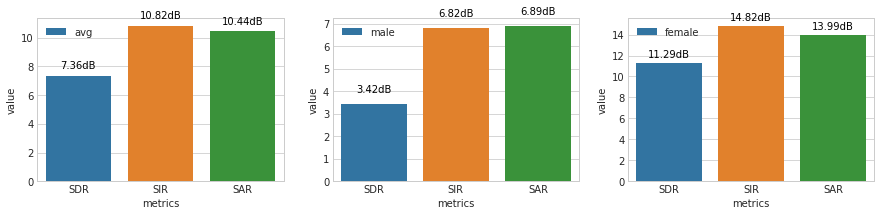

In [14]:
plot_bss_eval(sdr, sir, sar)

此图是作者在这组实验上给出来的结果，对应上面的第一个图，我复现结果比作者还要稍好一些。（我复现时使用的优化算法是Adam，作者使用的是L-BFGS，而且我的训练数据很可能远远多于作者使用的数据，因为执行循环移位算法时使用的间隔太小）
<img src='./solution/author_result_v2.png'/>

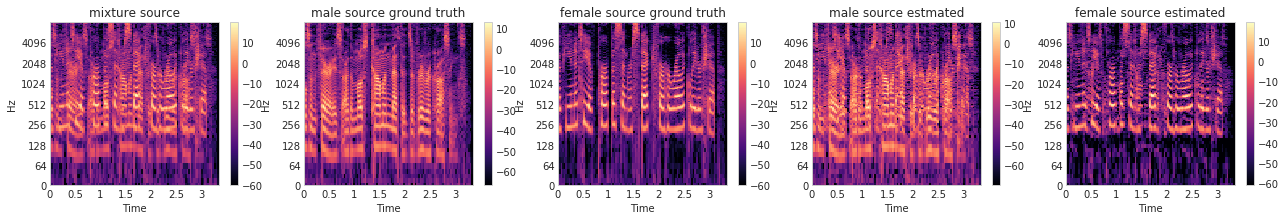

In [15]:
plot_spectra(np.squeeze(X_val).T, np.squeeze(Y1_val).T, np.squeeze(Y2_val).T, Y1_val_estimated, Y2_val_estimated)

上面几个是频谱图的对比，依次为混合信号，男性说话人真实信号，女性说话人真实信号，男性说话人估计信号，女性说话人估计信号的频谱图，可以明显看出男性说话人分离的效果稍差一些，女性说话人的分离效果会好一点。

In [16]:
# 测试第二版本的网络权重，设置gamma=0.1
# 构建阶段
# 重置默认图
tf.reset_default_graph()

# 创建占位符
X, Y_true1, Y_true2 = create_placeholder()

# 前向传播
# 输入混合时域频谱信号，输出两个信号源各自的频谱信号
Y_pred1, Y_pred2 = inference(X)

# 加载模型并运行图
saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    saver.restore(sess, weights_v2_path)
    Y1_estimated, Y2_estimated = sess.run([Y_pred1, Y_pred2], feed_dict={X: X_val})

INFO:tensorflow:Restoring parameters from ./weights/model_0.000300_512_-111.518.ckpt-7


In [17]:
# 删除batch_size维度并将频域维度转置到最前面
Y1_val_estimated = np.squeeze(Y1_estimated).T
Y2_val_estimated = np.squeeze(Y2_estimated).T

# 还原出原来的信号
y1_val_estimated = librosa.istft(Y1_val_estimated, hop_length=512, win_length=1024, length=53040)
y2_val_estimated = librosa.istft(Y2_val_estimated, hop_length=512, win_length=1024, length=53040)

# 将音频写入磁盘
librosa.output.write_wav('./val_set/y1_val_estimated_v2.wav', y1_val_estimated, 16000)
librosa.output.write_wav('./val_set/y2_val_estimated_v2.wav', y2_val_estimated, 16000)

In [18]:
reference_sources, estimated_sources = create_def_est_sources(y1_val, y2_val, y1_val_estimated, y2_val_estimated)
sdr, sir, sar, _ = \
    mir_eval.separation.bss_eval_sources(reference_sources, estimated_sources, compute_permutation=False)
print('平均SDR={:.2f}， SIR={:.2f}, SAR={:.2f}'.format(np.mean(sdr), np.mean(sir), np.mean(sar)))
print('男性SDR={:.2f}， SIR={:.2f}, SAR={:.2f}'.format(sdr[0], sir[0], sar[0]))
print('女性SDR={:.2f}， SIR={:.2f}, SAR={:.2f}'.format(sdr[1], sir[1], sar[1]))

平均SDR=7.60， SIR=11.63, SAR=10.17
男性SDR=3.78， SIR=7.94, SAR=6.52
女性SDR=11.42， SIR=15.32, SAR=13.83


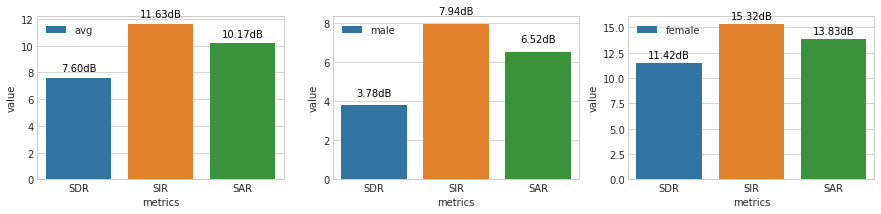

In [19]:
plot_bss_eval(sdr, sir, sar)

上面几个图印证了作者的说法，设置一个合适的$\gamma$值可以在一定程度上提高SIR，可以对比使用第一版本的权重的实验结果.

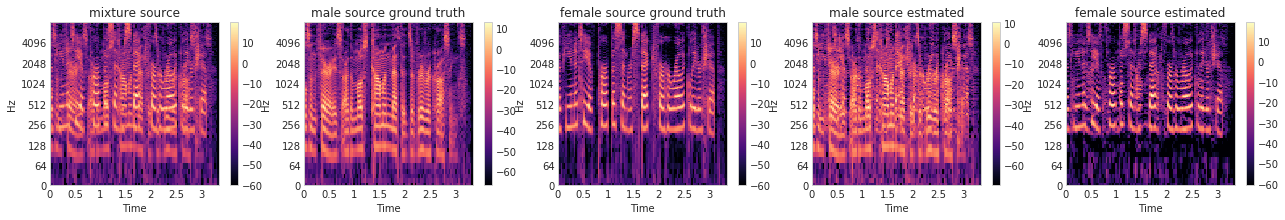

In [20]:
plot_spectra(np.squeeze(X_val).T, np.squeeze(Y1_val).T, np.squeeze(Y2_val).T, Y1_val_estimated, Y2_val_estimated)

In [21]:
SDR_v1, SIR_v1, SAR_v1 = extract_bss_eval_statistic('./crontab.log')
SDR_v2, SIR_v2, SAR_v2 = extract_bss_eval_statistic('./crontab2.log')

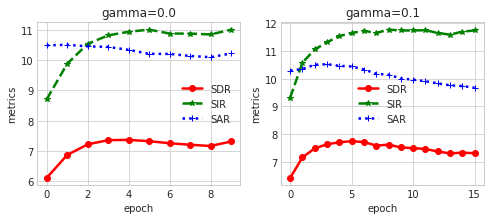

In [22]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.plot(SDR_v1, c='red', ls='-', lw=2.5, label='SDR', marker='o')
plt.plot(SIR_v1, c='green', ls='--', lw=2.5, label='SIR', marker='*')
plt.plot(SAR_v1, c='blue', ls=':', lw=2.5, label='SAR', marker='+')
plt.title('gamma=0.0')
plt.xlabel('epoch')
plt.ylabel('metrics')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(SDR_v2, c='red', ls='-', lw=2.5, label='SDR', marker='o')
plt.plot(SIR_v2, c='green', ls='--', lw=2.5, label='SIR', marker='*')
plt.plot(SAR_v2, c='blue', ls=':', lw=2.5, label='SAR', marker='+')
plt.title('gamma=0.1')
plt.xlabel('epoch')
plt.ylabel('metrics')
plt.legend(loc='best')

此处印证作者关于$\gamma$取值的第二个观点，合适的$\gamma$取值除了能提高SIR外，还能相对维持SDR和SAR不变

In [23]:
mix_val_audio = AudioSegment.from_wav('./val_set/mix_val.wav')
y1_val_audio = AudioSegment.from_wav('./val_set/y1_val.wav')
y2_val_audio = AudioSegment.from_wav('./val_set/y2_val.wav')
y1_val_estimated_audio = AudioSegment.from_wav('./val_set/y1_val_estimated_v2.wav')
y2_val_estimated_audio = AudioSegment.from_wav('./val_set/y2_val_estimated_v2.wav')

In [24]:
# 混合信号试听
mix_val_audio

In [25]:
# 男性说话人真实信号试听
y1_val_audio

In [26]:
# 女性说话人真实信号试听
y2_val_audio

In [27]:
# 男性说话人估计信号试听
y1_val_estimated_audio

In [28]:
# 女性说话人估计信号试听
y2_val_estimated_audio

**作者的实验结果试听: **<a href='https://sites.google.com/site/deeplearningsourceseparation/'>https://sites.google.com/site/deeplearningsourceseparation/</a>